In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import readFile, listFileNames, getPath
from wordcloud import WordCloud

In [3]:
def mapUniqueValues():
    """
    return [(deviceId, deviceName, deviceType, measurementType, fragment, series, unit), ...]
    """
    c8y_data = readFile('c8y_data.json')
    deviceIdMapping = {device['id']: device for device in c8y_data}
    
    uniqueValues = set()
    for fileName in listFileNames('measurements/typeFragmentSeries/'):      
        for device in readFile(fileName):
            deviceId = device['deviceId']
            deviceName = deviceIdMapping[deviceId]['name']
            deviceType = device['deviceType']
            
            for fragmentSeries in device['typeFragmentSeries']:
                measurement = fragmentSeries['measurement']
        
                if measurement:
                    measurementType = fragmentSeries['type']
                    fragment = fragmentSeries['fragment']
                    series = fragmentSeries['series']
                    measurementValue = measurement[fragment][series]
                    unit = measurementValue['unit'] if 'unit' in measurementValue else ''
                    
                    values = [deviceId, deviceName, deviceType, measurementType, fragment, series, unit]
                    values = ['' if value is None else value for value in values]
                    uniqueValues.add(tuple(values))  
    return uniqueValues

In [4]:
def formatMeasurementData(uniqueValues: list):
    """
    [{
      "device" : <device name>
      "type" : <device type>
      <fragment name> : {
        <series>: <unit>
      }
    }]
    """
    result = {}
    for deviceId, device_name, device_type, measurement_type, fragment, series, unit in uniqueValues:
        if deviceId in result:
            value = result[deviceId]
            if fragment not in value:
                value[fragment] = {}
            if series not in value[fragment]:
                value[fragment][series] = unit
        else:
            result[deviceId] = {
                "device": device_name,
                "type": device_type,
                fragment : {
                    series : unit
                }
            }
    return list(result.values())

In [5]:
uniqueValues = mapUniqueValues()
formattedValues = formatMeasurementData(uniqueValues)

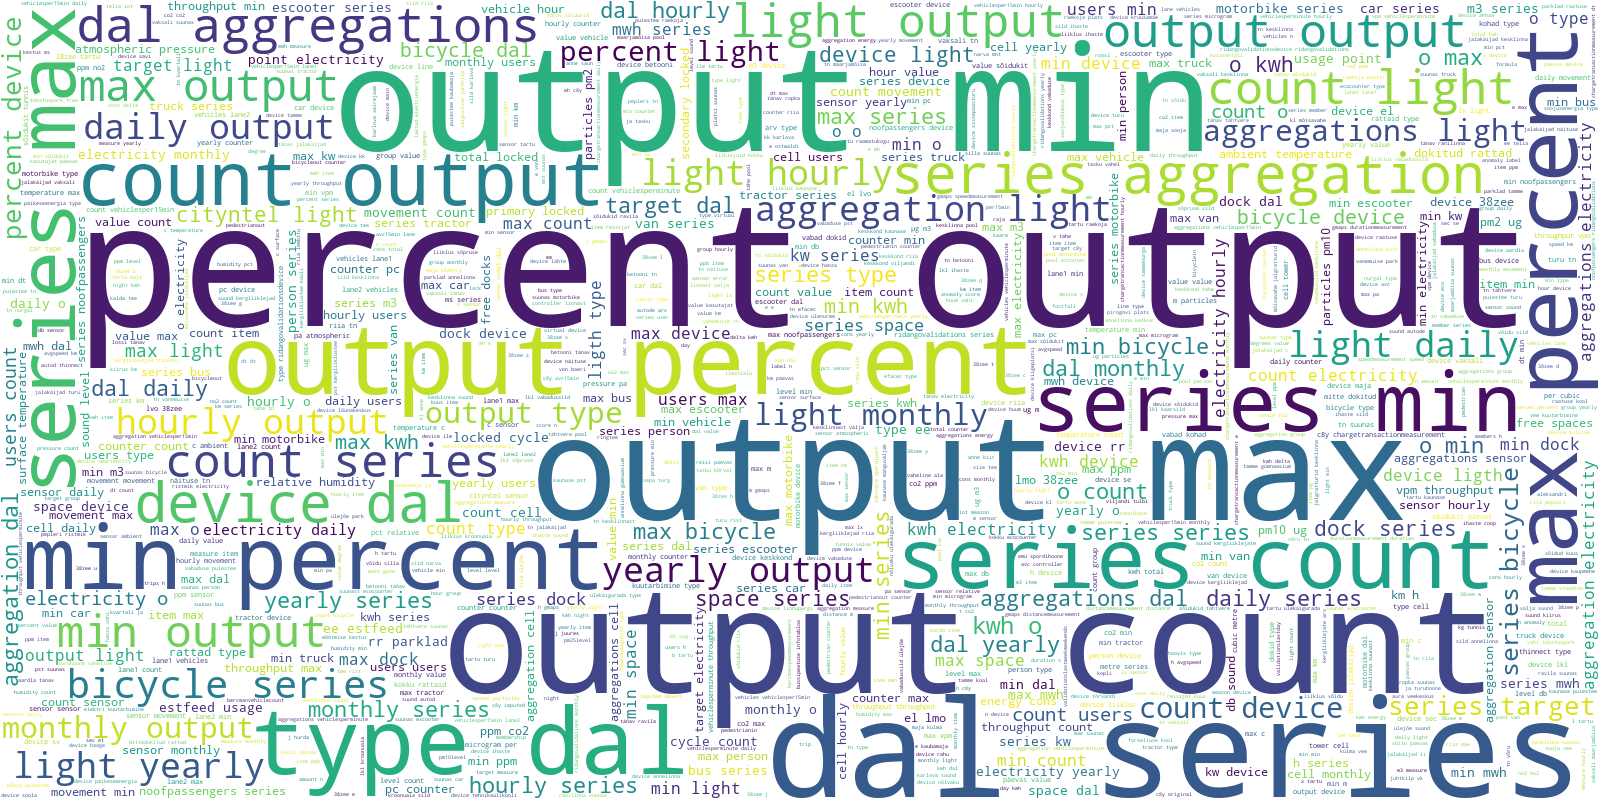

In [6]:
data_combined = ','.join([str(value) for value in formattedValues]).lower().replace("_", ' ').replace("'", '')
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1600, height=800)
wordcloud.generate(data_combined)
wordcloud.to_file(getPath(f'measurements wordcloud.png'))
wordcloud.to_image()